# 非監督的寵物分群
此專案提供一組寵物圖像，並將相同的動物分群在一起

經過訓練的捲積網路對圖像進行編碼，然後用分群算法應於用編碼特徵，接著再觀察集群間的效果是否有效

### 匯入套件

In [17]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical


## 資料集資訊

寵物圖片位於下方格式中

字串 + 數量 + '-' + 品種名

字串C表示貓D則是狗 
Number 是品種的序列號 
同一個動物相同品種都有自己的編號

例子: 
C1-阿比西尼亞貓
D6-吉娃娃

使用此資訊列出可用的品種並計算每個可用的圖像數量

In [18]:
# 圖片儲存的路徑
DIR = "./animal_images"

def dataset_stats():

    animal_characters = ['C', 'D']
    
    # 儲存統計後的資料
    stats = []
    
    for animal in animal_characters:
        # 獲取開頭為子目錄的列表
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [19]:
# 顯示Code&資料夾名稱&圖片數量
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
C1,C1-Abyssinian,198
C12,C12-Sphynx,200
C7,C7-Maine_coon,200
C8,C8-Persian,200
D1,D1-American_bulldog,200
D11,D11-Havanese,200
D21,D21-Scottish_terrier,199
D25,D25-Yorkshire_terrier,200
D9,D9-German_shorthaired,200


### 加載圖像

創建一個函數，為個一array給他代碼組數，

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [20]:
# 函式回傳一個字
# 之後調整為224x224大小

def load_images(codes):
    
    # 定義images來儲存圖像，labels則是儲存標籤
    images = []
    labels = []
    
    for code in codes:
        # 獲取代碼文件夾名稱
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            #建構文件路徑
            file_path = os.path.join(DIR, folder_name, file)
        
            # 讀取圖片
            image = cv2.imread(file_path)

            # 調整為 224 x 224
            image = cv2.resize(image, (224,224))

            # 將其從BGR轉成RGB，以便後續的繪圖處理(因為openCV會將圖片讀取為BGR
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 最後添加到array裡面
            images.append(image)
            labels.append(code)

    return images, labels

#### 接著為想要的品種選擇代碼並加載圖片和標籤

選擇兩個貓品種和兩個狗品種，但如果全部算進來結果更好玩，但相對計算量會更多

In [21]:
codes = ["C1", "C8", "D9", "D25"]
images, labels = load_images(codes)

### 圖片時間!

看看加載進來的品種，因為調整了大小以適應VGG的需求，故這些照片不會採用原本的縱橫比

In [22]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code C8


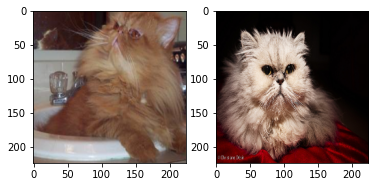

2 random images for code D25


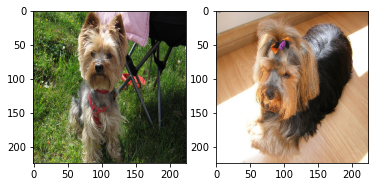

2 random images for code C1


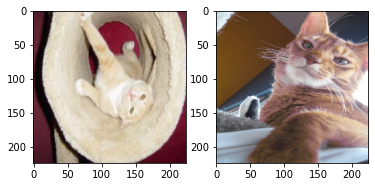

2 random images for code D9


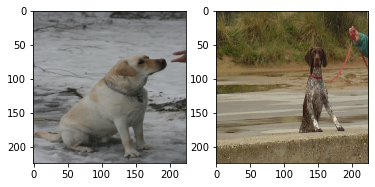

In [23]:
show_random_images(images, labels)

### 標準化...

將圖像和標籤轉換為NumPy，以便更輕鬆的處理他們;接著在將圖像傳給VGG19前對圖片進行標準化

In [24]:
def normalise_images(images, labels):

    # 轉換成numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # 標準化圖片
    images /= 255
    
    return images, labels

In [25]:
images, labels = normalise_images(images, labels)

### 是時候混合起來!

現在已經擁有4組的的圖片和標籤，是時候對他們進行洗牌，並拆分為3個不同的集合...訓練、驗證、測試

將使用sklearn中的'train_test_split'函式;他會幫助我們打亂數據，因為目前資料是有順序的

In [26]:
def shuffle_data(images, labels):

    # 擱置測試數據，直到這專案結束都不會碰到他們
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=798)
    
    return X_train, y_train

In [27]:
X_train, y_train = shuffle_data(images, labels)

### 加載預訓練的covnet模型
#### VGG16, VG19, ResNet50

刪掉頂部的密集層(因為這裡不需要對事物分類)，並使用imagenet權重加載keras模型。

In [28]:
# Load the models with ImageNet weights

vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

### 輸出...降到平坦

covnet模型提供代表的3D向量圖，所以我們需要將他展平，以便分群算法使用他們

In [29]:
def covnet_transform(covnet_model, raw_images):

    # 透過covnet傳遞訓練資料
    pred = covnet_model.predict(raw_images)

    # 展平array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


In [30]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


上面的單格執行結果展示了每個covnet賦予單張圖片的特徵數量。
將這些圖片的原始大小224x224x3=150528像素/特徵進行比較時，可以看到大大減少了分群算法必須處理的內容

 

希望這些減少的特徵數量更能使圖片結構擁有更有意義的特徵

### PCA(主成分分析)

雖然K-Means分群已經處理了這些數字，但高斯混合模型卻沒有，並且就算電腦耗盡內存也難以產生良好結果，
因此用PCA來降維使算法能應付。


In [31]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [32]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [33]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

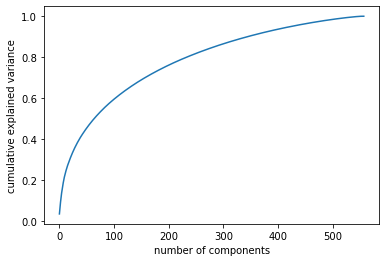

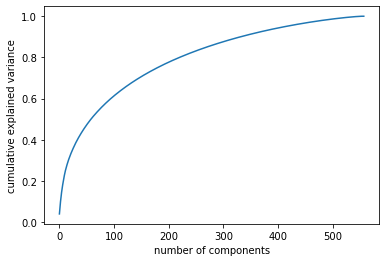

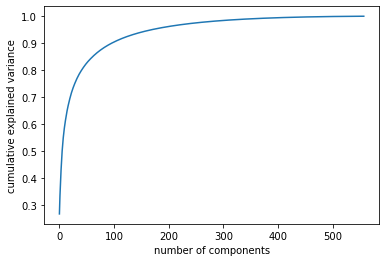

In [34]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [35]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### Cluster time

Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models.
While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC

In [36]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [37]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

### Ask the clustering algo what it thinks is what

In [38]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.3090353012084961 seconds

VGG19
Training took 0.15358901023864746 seconds

ResNet50
Training took 0.1436154842376709 seconds


In [39]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


GMM (PCA): 

VGG16
Training took 0.34906625747680664 seconds

VGG19
Training took 0.35028719902038574 seconds

ResNet50
Training took 0.3422408103942871 seconds


In [40]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:
Training took 4.432610988616943 seconds

VGG19:
Training took 5.25458288192749 seconds

ResNet50:
Training took 17.720682859420776 seconds


#### Attempts to run the Gaussian Mixtue Model on the outputs without PCA always give an out of memory error. I am therefore unable to test these and conclude that they are impractical to use.

In [41]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

Remember that the clustering algorith does not detect which images are cats and which are dogs, it only groups images that look alike together and assigns them a number arbitrarily. 

We now need to count how many of each label are in  each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [42]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [43]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [44]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2,3
C8,4,21,0,111
D25,92,30,9,11
C1,1,118,1,17
D9,0,41,98,4


In [45]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2,3
C8,4,21,0,111
D25,92,30,9,11
C1,1,118,1,17
D9,0,41,98,4


In [46]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1,2,3
C8,0,1,34,101
D25,0,14,86,42
C1,2,6,2,127
D9,0,113,0,30


We can see now that the Gaussian Model did not give a meaningful result. There are no clear dominant code for each cluster

In [47]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2,3
C8,3,83,2,48
D25,16,33,0,93
C1,11,71,54,1
D9,87,56,0,0


In [48]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2,3
C8,3,83,2,48
D25,16,33,0,93
C1,11,71,54,1
D9,87,56,0,0


In [49]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1,2,3
C8,4,2,39,91
D25,0,13,96,33
C1,44,9,1,83
D9,0,88,0,55


In [50]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1,2,3
C8,0,37,94,5
D25,10,67,30,35
C1,2,65,53,17
D9,20,35,21,67


In [51]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1,2,3
C8,0,37,94,5
D25,10,67,30,35
C1,2,65,53,17
D9,20,35,21,67


In [52]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1,2,3
C8,0,37,94,5
D25,10,67,30,35
C1,2,65,53,17
D9,20,35,21,67


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.

The models that made it through are:

1. KMeans VGG16
2. KMeans VGG16 PCA
3. KMeans VGG19
4. KMeans VGG19 PCA


Let's calculate some scores and see which one performs best.

### Cluster - Label assignment

In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [53]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["D9", "C1", "C8", "D25"]
vgg16_cluster_code_pca = ["D9", "C1", "C8", "D25"]

vgg19_cluster_code = ["C1", "C8", "D25", "D9"]
vgg19_cluster_code_pca = ["C1", "C8", "D25", "D9"]
# g_vgg19_cluster_code_pca = ["D25", "D19", "C8", "C1"]



### Replace the predicted clusters with their labels

In [54]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
# g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]


### Metrics

Now that we have two arrays, one with the predicted labels and one with the true labels, we can go crazy with performance scores... or we can just compute the F1 score

In [55]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.18932706   |   Accuracy: 0.18932706
KMeans VGG16 (PCA) 
	F1 Score: 0.18932706   |   Accuracy: 0.18932706

KMeans VGG19:  
	F1 Score: 0.13115222   |   Accuracy: 0.13115222
KMeans VGG19 (PCA):  
	F1 Score: 0.13115222   |   Accuracy: 0.13115222


### of note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.

### Testing Time

Ultimately, for best results, you would want to do this whole excercise every time you change your data in order to find out which model is the best for this particular data.

We can now then do the same thing for our testing data, and see if it gives the best accuracy again. We can keep testing this for more and more breed pairs to gain more confidence that our model works.

This is in the end an unsupevised learning excercise, and we would not be able to check which model is best for a particular set of data if we do not have labels for them. The closer your images are to the dataset images, the better chance you have of getting a high accuracy.

In [56]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels
    
    

599 599
2 random images for code D21


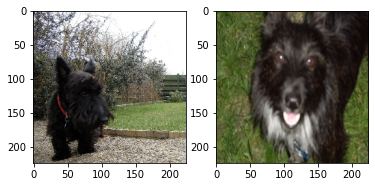

2 random images for code D9


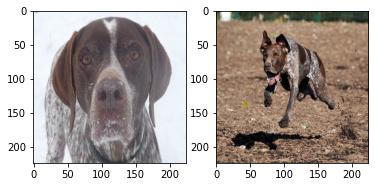

2 random images for code D11


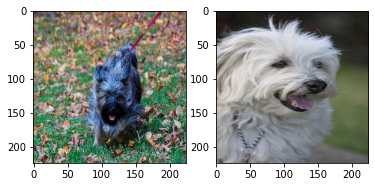

Training took 3.302184581756592 seconds
Training took 3.112370252609253 seconds
Training took 13.515642642974854 seconds
Training took 0.07480096817016602 seconds
Training took 0.0967416763305664 seconds
Training took 0.09574365615844727 seconds
Training took 0.13215327262878418 seconds
Training took 0.1632528305053711 seconds
Training took 0.16103887557983398 seconds
KMeans VGG16: 
      0    1   2
D21  32  100  13
D9    8   38  94
D11  84   44   6

KMeans VGG16 (PCA): 
      0    1   2
D21  32  100  13
D9    8   38  94
D11  84   44   6

GMM VGG16: 
       0   1    2
D21   75  67    3
D9    33   0  107
D11  116  12    6

KMeans VGG19: 
      0   1   2
D21  22  48  75
D9   79   5  56
D11  11  88  35

KMeans VGG19 (PCA): 
      0   1   2
D21  22  48  75
D9   79   5  56
D11  11  88  35
GMM VGG19 (PCA): 
      0   1   2
D21  22  48  75
D9   79   5  56
D11  11  88  35
KMeans Resnet50: 
      0   1   2
D21  37  19  89
D9   45  38  57
D11  42  13  79
Kmeans Resnet50 (PCA): 
      0   1   2
D

In [57]:
codes = ["D9", "D21", "D11"]
outputs = image_load_to_cluster_count(codes)

In [58]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["D11", "D21", "D9"]
vgg16_cluster_code_pca = ["D11", "D21", "D9"]

vgg19_cluster_code = ["D11", "D9", "D21"]
vgg19_cluster_code_pca = ["D11", "D9", "D21"]
g_vgg19_cluster_code_pca = ["D9", "D21", "D11"]


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.66862220   |   Accuracy: 0.66862220
KMeans VGG16 (PCA) 
	F1 Score: 0.66862220   |   Accuracy: 0.66862220

KMeans VGG19:  
	F1 Score: 0.20244440   |   Accuracy: 0.20244440
KMeans VGG19 (PCA):  
	F1 Score: 0.20244440   |   Accuracy: 0.20244440
GMM VGG19 (PCA) 
	F1 Score: 0.39866060   |   Accuracy: 0.39866060


Looks like VGG16 is doing the best again! Let's test one more time...

400 400
2 random images for code C8


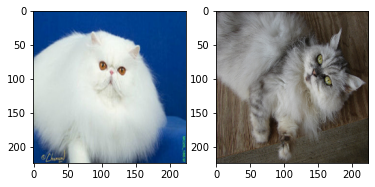

2 random images for code C12


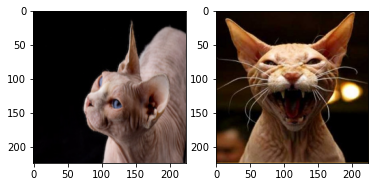

Training took 1.4054441452026367 seconds
Training took 1.5406787395477295 seconds
Training took 4.987167596817017 seconds
Training took 0.044879913330078125 seconds
Training took 0.04487895965576172 seconds
Training took 0.04288601875305176 seconds
Training took 0.02991938591003418 seconds
Training took 0.027924060821533203 seconds
Training took 0.029921293258666992 seconds
KMeans VGG16: 
       0    1
C8   130    5
C12    3  142

KMeans VGG16 (PCA): 
       0    1
C8   130    5
C12    3  142

GMM VGG16: 
     0    1
C8   0  135
C12  1  144

KMeans VGG19: 
       0    1
C8   131    4
C12   13  132

KMeans VGG19 (PCA): 
       0    1
C8   131    4
C12   13  132
GMM VGG19 (PCA): 
     0    1
C8   0  135
C12  1  144
KMeans Resnet50: 
      0    1
C8   17  118
C12  85   60
Kmeans Resnet50 (PCA): 
      0    1
C8   17  118
C12  85   60
GMM Resnet50 (PCA): 
       0   1
C8   128   7
C12   79  66


In [59]:
codes = ["C12", "C8"]
outputs = image_load_to_cluster_count(codes)

By now we can see that ResNet is performing terribly in all our tests. We can also see that PCA and non-PCA are the same, so we can just use the same cluster/code combinations for them, and that GMM has consistently performed same as or much worse than KMeans.

The two we will consider now are Kmeans VGG16 and VGG19

In [60]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["C8", "C12"]
vgg19_cluster_code = ["C12","C8"]

In [61]:
# Let's define a function for scores

def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
    vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
    vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
    print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

    print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
    print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))

In [62]:
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97137600   |   Accuracy: 0.97137600
KMeans VGG16 (PCA) 
	F1 Score: 0.97137600   |   Accuracy: 0.97137600

KMeans VGG19:  
	F1 Score: 0.05974285   |   Accuracy: 0.05974285
KMeans VGG19 (PCA):  
	F1 Score: 0.05974285   |   Accuracy: 0.05974285


VGG16 wins again!

Now let's try a cat and dog pair for our final test

400 400
2 random images for code D1


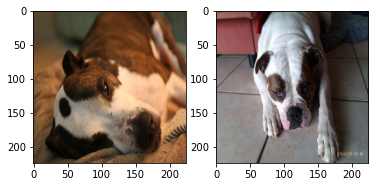

2 random images for code C7


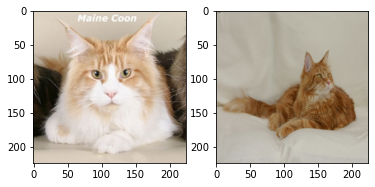

Training took 1.7571196556091309 seconds
Training took 1.629659652709961 seconds
Training took 6.049773454666138 seconds
Training took 0.05315375328063965 seconds
Training took 0.04587745666503906 seconds
Training took 0.049866437911987305 seconds
Training took 0.11170148849487305 seconds
Training took 0.03789806365966797 seconds
Training took 0.04188728332519531 seconds
KMeans VGG16: 
      0    1
C7  129    6
D1    1  144

KMeans VGG16 (PCA): 
      0    1
C7  129    6
D1    1  144

GMM VGG16: 
      0    1
C7    5  130
D1  142    3

KMeans VGG19: 
      0   1
C7   38  97
D1  145   0

KMeans VGG19 (PCA): 
      0   1
C7   38  97
D1  145   0
GMM VGG19 (PCA): 
      0   1
C7   38  97
D1  145   0
KMeans Resnet50: 
     0    1
C7  17  118
D1  80   65
Kmeans Resnet50 (PCA): 
     0    1
C7  17  118
D1  80   65
GMM Resnet50 (PCA): 
     0    1
C7  18  117
D1  80   65


In [63]:
codes = ["D1", "C7"]
outputs = image_load_to_cluster_count(codes)

In [64]:
vgg16_cluster_code = ["C7", "D1"]
vgg19_cluster_code = ["D1","C7"]
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97492805   |   Accuracy: 0.97492805
KMeans VGG16 (PCA) 
	F1 Score: 0.97492805   |   Accuracy: 0.97492805

KMeans VGG19:  
	F1 Score: 0.86017662   |   Accuracy: 0.86017662
KMeans VGG19 (PCA):  
	F1 Score: 0.86017662   |   Accuracy: 0.86017662


 ## It is possible to cluster images of different pet breeds 